In [20]:
import pandas as pd

In [21]:
df = pd.read_sas('data.sas7bdat')
# decode all object columns that are bytes to strings
for col in df.select_dtypes(include=['object']).columns:
    if df[col].apply(lambda x: isinstance(x, bytes)).any():
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [22]:
df.head()

,randhosp_id,randpat_id,pretrialexp,country,trialphase,phase,itt_treat,age,gender,deathcode,...,censor18,surv18,plan18,UKextra,disab_unknown6,vital_and_disabunknown6,disab_unknown18,vital_and_disabunknown18,treatment,haltcode
0,090,00001,2.0,UK,Open,2.0,0.0,81.0,1.0,E4,...,0.0,158.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,NaN
1,012,00002,1.0,SWEDEN,Open,2.0,1.0,92.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
2,043,00003,1.0,POLAND,Open,2.0,1.0,75.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
3,077,00004,2.0,UK,Open,2.0,0.0,60.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,I63
4,043,00005,1.0,POLAND,Open,2.0,0.0,88.0,1.0,NaN,...,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,rt-PA,NaN


In [23]:
df['deathcode'].value_counts()

deathcode
E1    536
E4    307
E3    194
E8     79
E9     77
E2     47
E7     21
Name: count, dtype: int64

In [24]:
# Keep only the rows where deathcode is NaN, e1 (cerebrovascular) or e3 (cardiovascular)
df = df[df['deathcode'].isna() | (df['deathcode'] == 'E1') | (df['deathcode'] == 'E3')]

In [25]:
from scripts.columns import SEVEN_DAY_FORM, SEVEN_DAY_FORM_FORMATS
from scripts.encode import encode_yn, encode_yndq, encode_GCSEYE, encode_GCSMOTOR, encode_GCSVERBAL, encode_gender

In [26]:
for col in SEVEN_DAY_FORM:
    if SEVEN_DAY_FORM_FORMATS[col] == 'YNDQ':
        df[col] = encode_yndq(df, col)
    elif SEVEN_DAY_FORM_FORMATS[col] == 'GCSEYE':
        df[col] = encode_GCSEYE(df, col)
    elif SEVEN_DAY_FORM_FORMATS[col] == 'GCSMOTOR':
        df[col] = encode_GCSMOTOR(df, col)
    elif SEVEN_DAY_FORM_FORMATS[col] == 'GCSVERBAL':
        df[col] = encode_GCSVERBAL(df, col)

df['gender'] = encode_gender(df, 'gender')

df.head()

,randhosp_id,randpat_id,pretrialexp,country,trialphase,phase,itt_treat,age,gender,deathcode,...,censor18,surv18,plan18,UKextra,disab_unknown6,vital_and_disabunknown6,disab_unknown18,vital_and_disabunknown18,treatment,haltcode
1,012,00002,1.0,SWEDEN,Open,2.0,1.0,92.0,Male,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
2,043,00003,1.0,POLAND,Open,2.0,1.0,75.0,Male,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
3,077,00004,2.0,UK,Open,2.0,0.0,60.0,Male,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,I63
4,043,00005,1.0,POLAND,Open,2.0,0.0,88.0,Male,NaN,...,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,rt-PA,NaN
5,016,00006,2.0,ITALY,Open,2.0,0.0,84.0,Female,E1,...,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,rt-PA,NaN


# Variable explanations

In [27]:
SELECTED_COLS = [
    'age', 'itt_treat', 'gender', 'deathcode', 'weight', 'glucose'
] + SEVEN_DAY_FORM

df = df[SELECTED_COLS]

In [28]:
from scripts.preprocess import preprocess

df, stats_df = preprocess(df)

df.head()

,age,itt_treat,deathcode,weight,glucose,gender_Male,gcs_eye_7_Spontaneously,gcs_eye_7_To Pain,gcs_eye_7_To command,gcs_verbal_7_Extend to pain,gcs_verbal_7_Localises movements to pain,gcs_verbal_7_None,gcs_verbal_7_Normal flex to pain,gcs_motor_7_Inappropriate words,gcs_motor_7_Noises only,gcs_motor_7_None,"gcs_motor_7_Orientated in time, place and person",liftarms_7_1,ablewalk_7_1,indepinadl_7_1
1,1.247552,1.012660,0,-0.294931,-0.511629,True,True,False,False,False,True,False,False,False,False,False,False,True,True,True
2,-0.100204,1.012660,0,-0.161046,-0.511629,True,True,False,False,False,True,False,False,False,False,False,False,True,True,True
3,-1.289401,-0.987104,0,-0.428815,-0.917866,True,True,False,False,False,True,False,False,False,False,False,False,True,True,False
4,0.930433,-0.987104,0,-1.165180,-0.105393,True,True,False,False,False,True,False,False,False,False,False,False,True,True,True
5,0.613314,-0.987104,1,-0.495758,-0.511629,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (e.g., 80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Optionally, display the shapes of the splits
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2003, 20)
Test shape: (501, 20)


In [30]:
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
import numpy as np

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train.drop(columns=['deathcode']).values
y_train = df_train['deathcode'].values
X_test = df_test.drop(columns=['deathcode']).values
y_test = df_test['deathcode'].values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_aucs = []
fold_accs = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    _X_train, _X_val = X_train[train_idx], X_train[val_idx]
    _y_train, _y_val = y_train[train_idx], y_train[val_idx]
    
    clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, use_label_encoder=False, eval_metric="logloss")
    clf.fit(_X_train, _y_train, eval_set=[(_X_val, _y_val)], verbose=False)
    models.append(clf)
    
    y_val_pred_proba = clf.predict_proba(_X_val)[:, 1]
    y_val_pred = clf.predict(_X_val)
    
    from sklearn.metrics import roc_auc_score, accuracy_score
    auc = roc_auc_score(_y_val, y_val_pred_proba)
    acc = accuracy_score(_y_val, y_val_pred)
    fold_aucs.append(auc)
    fold_accs.append(acc)
    print(f"Fold {fold+1}: AUC = {auc:.3f}, Accuracy = {acc:.3f}")

print(f"\nMean AUC: {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")
print(f"Mean Accuracy: {np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}")

# For further use, you can pick the last trained model or retrain on all data
clf = models[-1]

Fold 1: AUC = 0.850, Accuracy = 0.848
Fold 2: AUC = 0.869, Accuracy = 0.863
Fold 3: AUC = 0.847, Accuracy = 0.843
Fold 4: AUC = 0.857, Accuracy = 0.840
Fold 5: AUC = 0.870, Accuracy = 0.835

Mean AUC: 0.858 ± 0.010
Mean Accuracy: 0.846 ± 0.010


/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:04] WARNING: /Users/runner/work/xgboost/xgb

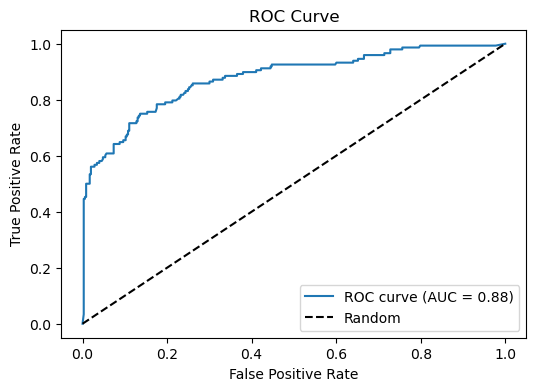

Accuracy: 0.85


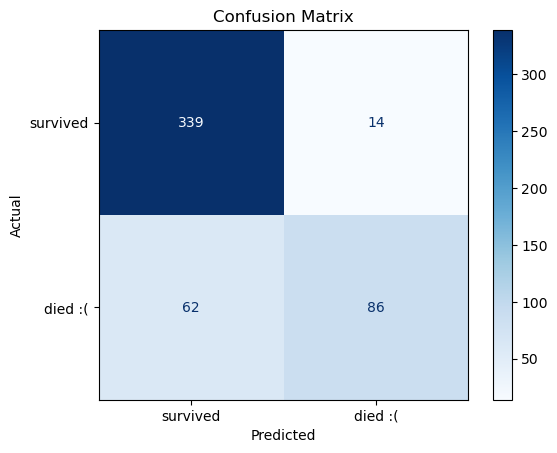

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and classes
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["survived", "died :("])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
